# 0. 구글 드라이브와 연결 및 각종 라이브러리 다운로드
## 구글 드라이브 연결

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 각종 라이브러리 설치 및 로드

In [7]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install soynlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import re
from soynlp.normalizer import *

In [ ]:
nltk.download()

# 1. 데이터 로드
## 데이터 로드

In [12]:
path = '/content/drive/MyDrive/CUAI/'
train0 = pd.read_excel(path + '감성대화말뭉치(최종데이터)_Training.xlsx', engine = 'openpyxl')
validation0 = pd.read_excel(path + '감성대화말뭉치(최종데이터)_Validation.xlsx', engine = 'openpyxl')
nsmc0 = pd.read_csv(path + 'nsmc_data.txt', sep = '\t')

### 데이터 확인

In [13]:
train0.head(2)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN


In [14]:
validation0.head(2)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN


In [15]:
nsmc0.tail(2)

,id,document,label
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0
199999,8548411,포풍저그가나가신다영차영차영차,0


### Sample 개수 확인

In [16]:
print('train0의 sample의 수: {}개'.format(train0.shape[0]))
print('validation0의 sample의 수: {}개'.format(validation0.shape[0]))
print('nsmc0의 sample의 수: {}개'.format(nsmc0.shape[0]))
print('모든 샘플의 수: {}개'.format(train0.shape[0]+validation0.shape[0]+nsmc0.shape[0]))

train0의 sample의 수: 40879개
validation0의 sample의 수: 5130개
nsmc0의 sample의 수: 200000개
모든 샘플의 수: 246009개


# 2. 데이터 정제
## Naver 데이터 확인 및 정제
#### 1. 결측값 제거

In [17]:
nsmc0.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [18]:
#결측값 제거 후 nsmc1에 저장
nsmc1 = nsmc0.dropna()

#### 2. 중복값 제거

In [19]:
# 중복값 개수 확인
print('nsmc1의 sample의 수: {}개'.format(nsmc1.shape[0]))
print('nsmc1의 document 종류의 수: {}개'.format(nsmc1['document'].nunique()))

nsmc1의 sample의 수: 199992개
nsmc1의 document 종류의 수: 194543개


In [20]:
# 중복 제거 후 nsmc2에 저장
nsmc2 = nsmc1.drop_duplicates(subset=['document'], ignore_index=True)

In [21]:
#중복 제거 확인
print('nsmc2의 sample의 수: {}개'.format(nsmc2.shape[0]))
print('nsmc2의 document 종류의 수: {}개'.format(nsmc2['document'].nunique()))

nsmc2의 sample의 수: 194543개
nsmc2의 document 종류의 수: 194543개


#### 3. 노이즈 제거
##### 글자가 아닌 것 지우기

In [22]:
nsmc2['document'] = nsmc2['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##### Normalize 진행

In [23]:
#ㅜ를 ㅠ로 바꿔주기
nsmc2['document'] = nsmc2['document'].map(lambda sent: re.sub('ㅜ', 'ㅠ', sent))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
#normalize진행 => 여러번 연속된 문자를 통일된 문자로 바꿔줌
nsmc2['document'] = nsmc2['document'].map(lambda sent: emoticon_normalize(sent, num_repeats=2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
#위에서 normalize를 진행하여도 3개가 연속된 것은 normalize되지 않는것을 확인
  #하나하나 바꿔줌
nsmc2['document'].map(lambda sent: re.sub('ㅋㅋㅋ', 'ㅋㅋ', sent)) #ㅋㅋㅋ 을 ㅋㅋ으로 바꾸기
nsmc2['document'].map(lambda sent: re.sub('ㅎㅎㅎ', 'ㅎㅎ', sent)) #ㅎㅎㅎ 을 ㅎㅎ으로 바꾸기
nsmc2['document'].map(lambda sent: re.sub('ㅠㅠㅠ', 'ㅠㅠ', sent)) #ㅠㅠㅠ 을 ㅠㅠ으로 바꾸기
nsmc2['document'].map(lambda sent: re.sub('ㅉㅉㅉ', 'ㅉㅉ', sent)) #ㅉㅉㅉ 을 ㅉㅉ으로 바꾸기
nsmc2['document'].map(lambda sent: re.sub('ㅡㅡㅡ', 'ㅡㅡ', sent)) #ㅡㅡㅡ 을 ㅡㅡ으로 바꾸기

0                                        어릴때보고 지금다시봐도 재밌어ㅋㅋ
1         디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...
2                          폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고
3          와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지
4                                안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화
                                ...                        
194538                                         포켓 몬스터 짜가 ㅡㅡ
194539                                                  쓰레기
194540                      완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다
194541                  왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
194542                                      포풍저그가나가신다영차영차영차
Name: document, Length: 194543, dtype: object

#### 4. 마지막으로 결측치, 중복값 제거

In [26]:
#중복값 제거
nsmc3 = nsmc2.drop_duplicates(subset=['document'], ignore_index=True)

In [27]:
#결측치 제거
nsmc3 = nsmc3.dropna()

## AI-Hub(train, validation)데이터 전처리
#### 1. 결측값 제거 & 필요한 열만 추리기

In [28]:
# 결측값 개수 확인
print(train0.isnull().sum())
print('-'*20)
print(validation0.isnull().sum())

번호            0
연령            0
성별            0
상황키워드         0
신체질환          0
감정_대분류        0
감정_소분류        0
사람문장1         0
시스템응답1        0
사람문장2         0
시스템응답2        0
사람문장3      9820
시스템응답3     9820
사람문장4     39407
시스템응답4    39517
dtype: int64
--------------------
번호           0
연령           0
성별           0
상황키워드        0
신체질환         0
감정_대분류       0
감정_소분류       0
사람문장1        0
시스템응답1       0
사람문장2        0
시스템응답2       0
사람문장3     1256
시스템응답3    1256
사람문장4     4979
시스템응답4    4994
dtype: int64


In [29]:
# 감정_대분류 표현의 종류 확인 -> 긍정 표현:1, 부정 표현:0으로 변경 예정

print(train0['감정_대분류'].value_counts())
print('-'*20)
print(validation0['감정_대분류'].value_counts())

# 출력결과 train0에는 불안과 기쁨이 2종류로 존재하는데
# 이는 불안과 기쁨 뒤에 공백이 존재하는 것들이 끼어있어 그런 것

불안     7328
분노     6920
슬픔     6915
기쁨     6730
상처     6624
당황     6360
불안        1
기쁨        1
Name: 감정_대분류, dtype: int64
--------------------
불안    907
분노    873
슬픔    861
기쁨    841
당황    832
상처    816
Name: 감정_대분류, dtype: int64


In [30]:
# 필요한 열만 가져와 각각 train1, validation1에 저장
train1 = train0[['감정_대분류', '사람문장1', '사람문장2']]
validation1 = validation0[['감정_대분류', '사람문장1', '사람문장2']]

In [31]:
# 전체 감정label을 0으로 우선 만든 뒤 '기쁨'에 해당하는 것만 1로 변경

train1['label'] = 0
validation1['label'] = 0

train1.loc[train1['감정_대분류']=='기쁨', 'label'] = 1
train1.loc[train1['감정_대분류']=='기쁨 ', 'label'] = 1
validation1.loc[validation1['감정_대분류']=='기쁨', 'label'] = 1
validation1.loc[validation1['감정_대분류']=='기쁨 ', 'label'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [32]:
# 결측 없는지 최종 확인
print(train1.isnull().sum())
print('-'*20)
print(validation1.isnull().sum())

감정_대분류    0
사람문장1     0
사람문장2     0
label     0
dtype: int64
--------------------
감정_대분류    0
사람문장1     0
사람문장2     0
label     0
dtype: int64


#### 2. 중복값 제거

In [33]:
# 전체 행과 열의 수 확인
print(train1.shape)
print(validation1.shape)

(40879, 4)
(5130, 4)


In [34]:
# 사람문장1, 사람문장2, label의 종류 확인

print(train1['사람문장1'].nunique(), train1['사람문장2'].nunique(), train1['label'].nunique())
print(validation1['사람문장1'].nunique(), validation1['사람문장2'].nunique(), validation1['label'].nunique())

# 행의 수와 사람문장의 종류의 수가 같지 않다는 것은
# 중복된 문장이 들어가 있다는 뜻!

39415 38878 2
5103 5096 2


In [35]:
# 중복 제거

train1.drop_duplicates(subset=['사람문장1'], inplace=True, ignore_index=True)
train1.drop_duplicates(subset=['사람문장2'], inplace=True, ignore_index=True)

validation1.drop_duplicates(subset=['사람문장1'], inplace=True, ignore_index=True)
validation1.drop_duplicates(subset=['사람문장2'], inplace=True, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [36]:
# 중복 제거 확인
print(train1.shape[0], train1['사람문장1'].nunique(), train1['사람문장2'].nunique())
print(validation1.shape[0], validation1['사람문장1'].nunique(), validation1['사람문장2'].nunique())

38713 38713 38713
5095 5095 5095


##### 3. 하나의 document의 문장 개수 확인 & 문장 분리

In [37]:
# train1을 사람문장1(train2_1), 사람문장2(train2_2)로 분리(validation도 동일)

train2_sent1 = train1[['사람문장1', 'label']]
train2_sent2 = train1[['사람문장2', 'label']]
validation2_sent1 = validation1[['사람문장1', 'label']]
validation2_sent2 = validation1[['사람문장2', 'label']]

In [38]:
# 문장 개수 파악에 사용할 sent_tokenize를 import
from nltk.tokenize import sent_tokenize

In [39]:
train2_sent1['nsent'] = train2_sent1['사람문장1'].map(sent_tokenize).map(len)
train2_sent2['nsent'] = train2_sent2['사람문장2'].map(sent_tokenize).map(len)
validation2_sent1['nsent'] = validation2_sent1['사람문장1'].map(sent_tokenize).map(len)
validation2_sent2['nsent'] = validation2_sent2['사람문장2'].map(sent_tokenize).map(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [40]:
#head찍어보기
train2_sent1.head(2)

,사람문장1,label,nsent
0,아내가 드디어 출산하게 되어서 정말 신이 나.,1,1
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,0,1


In [41]:
# 문장 개수 확인
print(train2_sent1['nsent'].value_counts())
print('-'*30)
print(train2_sent2['nsent'].value_counts())
print('-'*30)
print(validation2_sent1['nsent'].value_counts())
print('-'*30)
print(validation2_sent2['nsent'].value_counts())

1    28421
2    10033
3      239
4       20
Name: nsent, dtype: int64
------------------------------
1    24254
2    13612
3      779
4       58
5        9
6        1
Name: nsent, dtype: int64
------------------------------
1    3810
2    1238
3      45
4       2
Name: nsent, dtype: int64
------------------------------
1    3250
2    1724
3     116
4       5
Name: nsent, dtype: int64


In [42]:
# 문장 개수가 2개 이하인 것들만 새로운 변수에 저장

train3_sent1 = train2_sent1.loc[train2_sent1['nsent']<=2]
train3_sent2 = train2_sent2.loc[train2_sent2['nsent']<=2]
validation3_sent1 = validation2_sent1.loc[validation2_sent1['nsent']<=2]
validation3_sent2 = validation2_sent2.loc[validation2_sent2['nsent']<=2]
train3_sent1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38454 entries, 0 to 38712
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사람문장1   38454 non-null  object
 1   label   38454 non-null  int64 
 2   nsent   38454 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [43]:
# 사람문장이라는 열 이름을 document로 변경
train3_sent1.columns = ['document', 'label', 'nsent']
train3_sent2.columns = ['document', 'label', 'nsent']
validation3_sent1.columns = ['document', 'label', 'nsent']
validation3_sent2.columns = ['document', 'label', 'nsent']

In [44]:
train3_1 = train3_sent1.reset_index()
train3_2 = train3_sent2.reset_index()
validation3_1 = validation3_sent1.reset_index()
validation3_2 = validation3_sent2.reset_index()

In [45]:
train3_1.tail() #index가 찍히는 모습. 다시 document랑 label만 가져와야 할 것 같다.
                  #어차피 trans_df를 거치면 document와 label만 있을 것.

,index,document,label,nsent
38449,38708,최 영감이 노인들에게 나를 이상한 사람으로 이야기해서 답답하고 억울해.,0,1
38450,38709,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,1,1
38451,38710,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,0,2
38452,38711,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,1,1
38453,38712,친구 관계가 너무 힘들어. 베푸는 만큼 돌아오지 않는 것 같아.,0,2


##### 4.하나의 document로 묶인 2개의 문장들을 각각 다른 document로 분리
- 분리할 때는 같은 라벨링을 사용한다.

In [46]:
# 문장 2개를 각각 하나의 문장으로 분리해줄 함수 정의
def trans_df(df):
  temp = pd.DataFrame({'document':[], 'label':[]}) #빈 데이터 프레임
  num = 0
  for i in range(df.shape[0]): #인자로 받은 df의 행 개수만큼 반복한다
    if(i%10000 == 0):
      print(i,'번째') #번호 출력
    for s in sent_tokenize(df['document'][i]): #df의 document열의 각 행을 sent_tokenize하여 문장 분리
      temp.loc[num] = [s, df['label'][i]] #앞서 정의했던 빈 df의 num번째 행에 차례대로 document와 label을 추가 
                                            #같은 i이기 때문에, 같은 라벨이 부여됨.
      num = num+1 #다음 행번호
  return temp

In [47]:
#분리한 데이터를 train4, validation4에 저장
train4_sent1 = trans_df(train3_1)
train4_sent2 = trans_df(train3_2)
validation4_sent1 = trans_df(validation3_1)
validation4_setn2 = trans_df(validation3_2)

0 번째
10000 번째
20000 번째
30000 번째
0 번째
10000 번째
20000 번째
30000 번째
0 번째
0 번째


##### 5. aihub데이터 합치기 & 문자 아닌것 제거

In [48]:
#데이터 합치기
df_list = [train4_sent1, train4_sent2, validation4_sent1, validation4_setn2]
train_df = pd.concat(df_list, ignore_index=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112949 entries, 0 to 112948
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   document  112949 non-null  object 
 1   label     112949 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


In [49]:
#문자 아닌것 제거
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [50]:
#중복 제거 
train_df.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)

#결측치 제거
train_df = train_df.dropna()

In [51]:
train_df.columns

Index(['document', 'label'], dtype='object')

In [52]:
nsmc4 = nsmc3[['document', 'label']]

## Ai-hub데이터와 nsmc데이터 합치기
- 파일로 저장하는 것까지 포함
  - 파일 이름: train_data.xlsx

In [53]:
data = train_df.append(nsmc4, ignore_index= True)

In [54]:
#중복 제거 
data.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)

#결측치 제거
data = data.dropna()

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294669 entries, 0 to 294668
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   document  294669 non-null  object 
 1   label     294669 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.7+ MB


In [56]:
data.to_excel('/content/drive/MyDrive/CUAI/train_data.xlsx')

In [61]:
data

,document,label
0,아내가 드디어 출산하게 되어서 정말 신이 나,1.0
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,0.0
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,0.0
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야,1.0
4,너무 행복해,1.0
...,...,...
294664,개연성이 없어요 별루다,0.0
294665,포켓 몬스터 짜가 ㅡㅡ,0.0
294666,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,0.0
294667,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0.0


##### train, test 데이터 나누기

In [94]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42, shuffle=True)

In [95]:
train_data['label'].value_counts()[0]/train_data.shape[0]

0.6196623544689843

In [96]:
test_data['label'].value_counts()[0]/test_data.shape[0]

0.619672042134984

In [98]:
print(train_data.isnull().sum(axis = 0), test_data.isnull().sum(axis=0))

document    0
label       0
dtype: int64 document    0
label       0
dtype: int64


# 3. 토큰화

In [120]:
#레이블을 Y_train, Y_test에 저장
Y_train = np.array(train_data['label'])
Y_test = np.array(test_data['label'])

In [128]:
#불용어 정의
stopwords = ['어', '나', '저희', '을', '를', '에', '의', '가', '으로', '로', '에게', '다', '이', '로써', '등', '등등', '여', '조금', '좀','몇',
             '하다', '들', '은', '이야', '게', '도', '것', '이야', '는', '내', '에서', '하고', '고', '요즘', '랑']

#okt 형태소 분석
#def okt_tokens(text):
#  okt = Okt()
#  aihub_train_x = []
#  for i in range(0, len(text)):
#    tokenized_sent = okt.morphs(text[i], stem=True)
#    stopwords_removed_sent = [word for word in tokenized_sent if not word in stopwords]
#    aihub_train_x.append(stopwords_removed_sent)
    
#  return aihub_train_x

#꼬꼬마 형태소 분석
#def kkm_tokens(text):
#  kkma = Kkma()
#  aihub_train_x = []
#  for i in range(0, len(text)):
#    tokenized_sent =kkma.morphs(text[i])
#    stopwords_removed_sent = [word for word in tokenized_sent if not word in stopwords]
#    aihub_train_x.append(stopwords_removed_sent)

#  return aihub_train_x

#코모란 형태소 분석
#def komoran_tokens():
#  komoran = Komoran()
#  aihub_train_x = []
#  for i in range(0, len(text)):
#    tokenized_sent = komoran.morphs(text[i])
##    stopwords_removed_sent = [word for word in tokenized_sent if not word in stopwords]
#   aihub_train_x.append(stopwords_removed_sent)

okt = Okt()
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 221001/221001 [20:01<00:00, 183.93it/s]


In [129]:
okt = Okt()
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 73668/73668 [07:37<00:00, 160.88it/s]


###### 파일로 저장해놓기

In [130]:
#토큰화 된 X_test를 파일로 저장(파일 이름: X_test)
X_test = np.array(X_test)
np.save('/content/drive/MyDrive/CUAI/X_test.npy', X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [131]:
X_test

array([list(['네', '엄마', '때문', '우리', '부모님', '죽다', '네', '엄마', '때문', '이라고', '사랑', '뭔', '개', '소리', '냐', '확', '죽이다', '부르다']),
       list(['저', '나이', '같다', '영화', 'ㅋ']),
       list(['내용', '진짜', '지루함', '재미없다']), ...,
       list(['정말', '재미', '없다', '유치원', '생', '이나', '초등학생', '보다', '좋다', '도움', '되다', '같다']),
       list(['아이러니', '한', '상황', '황', '망하다', '도출', '점']),
       list(['가족', '과', '대화', '않다'])], dtype=object)

In [132]:
#토큰화 된 X_train를 파일로 저장(파일이름: X_train)
X_train = np.array(X_train)
np.save('/content/drive/MyDrive/CUAI/X_train.npy', X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [133]:
X_train

array([list(['의사', '선생님', '당장', '금연', '과', '금주', '않다', '암', '걸리다']),
       list(['세번', '째다', '빼다', '별로', '이다', '세번', '쨰', '그나마', '재미', '있다']),
       list(['직장', '계속', '따돌림', '당하다', '있다']), ...,
       list(['최고', '최고', '사랑', '싶다']),
       list(['무스', '졸멋', '걍', '졸멋', '개', '소름']),
       list(['전우치', '보다', '맛', '일주일', '살', '있다', 'ㅋㅋ', '말', '뭐'])],
      dtype=object)

In [134]:
Y_train = np.array(Y_train)
np.save('/content/drive/MyDrive/CUAI/Y_train.npy', Y_train)

In [135]:
Y_test = np.array(Y_test)
np.save('/content/drive/MyDrive/CUAI/Y_test.npy', Y_test)

#### 단어집합 생성 및 크기 확인

In [136]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [137]:
#단어 집합 크기 확인
len(tokenizer.word_index)

45922

##### 단어의 등장 빈도를 고려하여 vocab size 설정

In [138]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45922
등장 빈도가 2번 이하인 희귀 단어의 수: 24467
단어 집합에서 희귀 단어의 비율: 53.27947389051
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4196493445399678


In [106]:
vocab_size = 21375

##### 정수 인코딩

In [205]:
X_train = np.load(path + 'X_train.npy', allow_pickle=True)
X_test = np.load(path + 'X_test.npy', allow_pickle=True)
Y_train = np.load(path + 'Y_train.npy', allow_pickle=True)
Y_test = np.load(path + 'Y_test.npy', allow_pickle=True)

In [206]:
X_train.shape

(221001,)

In [207]:
Y_train.shape

(221001,)

In [208]:
X_test.shape

(73668,)

In [209]:
Y_test.shape

(73668,)

In [210]:
tokenizer = Tokenizer(vocab_size)  #vocab size 정의
tokenizer.fit_on_texts(X_train)

#X_train 정수인코딩 진행
X_train = tokenizer.texts_to_sequences(X_train)


In [211]:
#결과 확인
X_train[:3]

[[790, 435, 1295, 4097, 24, 10607, 10, 557, 396],
 [2232, 2603, 411, 148, 8, 2232, 762, 75, 3],
 [249, 159, 759, 229, 3]]

In [212]:
#X_test 정수인코딩 진행
X_test = tokenizer.texts_to_sequences(X_test)

In [213]:
#결과 확인
X_test[2]

[74, 21, 622, 85]

In [214]:
#모두 넘파이 배열로 바꿔준다.
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [215]:
#X_train결측치 확인
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] 


In [216]:
len(drop_train) #결측치 254개 확인

254

In [217]:
#결측치 지우기 전
X_train.shape[0]

221001

In [218]:
#Train데이터의 결측치 제거
X_train = np.delete(X_train, drop_train, axis=0)
Y_train = np.delete(Y_train, drop_train, axis=0)

In [219]:
#결측치 지우고난 후
X_train.shape[0]

220747

In [220]:
#X_test결측치 확인
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1] 

In [221]:
len(drop_test) #108개의 결측치 확인

108

In [222]:
#test 결측치 지우기 전
X_test.shape[0]

73668

In [223]:
#test데이터의 결측치 제거
X_test = np.delete(X_test, drop_test, axis=0)
Y_test = np.delete(Y_test, drop_test, axis=0)

In [224]:
#test 결측치 지우고 난 후
X_test.shape[0]

73560

#### 문장의 길이를 고려하여 패딩 사이즈 설정

최대 길이 : 68
평균 길이 : 9.490146571237558


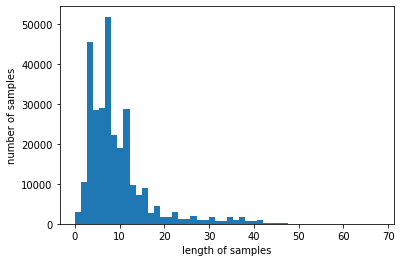

In [87]:
print('최대 길이 :',max(len(review) for review in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [88]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [89]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.63554700358708


In [228]:
#패딩 => 길이는 30
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
print(X_train)

#파일로 저장
np.save('/content/drive/MyDrive/CUAI/X_train_padding.npy', X_train)

[[  790   435  1295 ...     0     0     0]
 [ 2232  2603   411 ...     0     0     0]
 [  249   159   759 ...     0     0     0]
 ...
 [   42    42    91 ...     0     0     0]
 [ 9355 17646   555 ...     0     0     0]
 [10490     2   856 ...     0     0     0]]


In [229]:
X_test = pad_sequences(X_test, maxlen =max_len, padding = 'post')
print(X_test)

#파일로 저장 
np.save('/content/drive/MyDrive/CUAI/X_test_padding.npy', X_test)

[[  77  180   72 ...    0    0    0]
 [ 108  182    6 ...    0    0    0]
 [  74   21  622 ...    0    0    0]
 ...
 [  12   75    4 ...    0    0    0]
 [4927   13  375 ...    0    0    0]
 [ 140   24  508 ...    0    0    0]]


# 4. 모델 정의 및 임베딩 레이어 구축